In [218]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy
import nengo
%matplotlib inline

In [220]:
inputs = pickle.load(open("/Users/bptripp/code/nengo-FPGA/v1/inputs.p", "rb" ))

dt = .001

class InputWrapper: 
    def __init__(self, inputs, index): 
        self.inputs = inputs
        self.index = index
    
    def __call__(self, t): 
        step_num = np.round(t/dt)
        # clamp to maximum size of array
        if step_num >= self.inputs.shape[2]:
            step_num = self.inputs.shape[2] - 1 
        return self.inputs[self.index,:,step_num]
        
model = nengo.Model('Motion', seed=1)

n = inputs.shape[0]
# n = 50

input_nodes = []
input_probes = []
for i in range(n): 
    wrapper = InputWrapper(inputs, i)
    node = nengo.Node(output=wrapper, size_in=0, size_out=inputs.shape[1], label="Gabor")
    input_nodes.append(node)
    input_probes.append(nengo.Probe(node, 'output'))


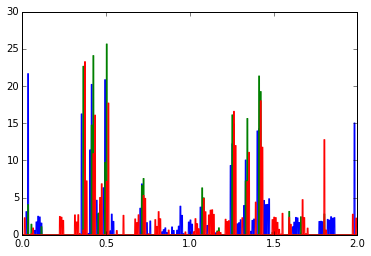

In [221]:
# check the inputs (should be bursts of blue-green-red) ...
sim = nengo.Simulator(model)
sim.run(inputs.shape[2]*dt)
plt.plot(sim.trange(), sim.data(input_probes[1]))

In [222]:
n_dirs = 2 #Number of V1 oscillator directions
n_speeds = 3 #Number of V1 oscillator speeds
tcs = np.array([40,100,160])*0.001 #Time constants corresponding to the 20... ms half periods in the thesis for speeds
# ...except where they don't because using 40 instead of 65 gives an unrepresentable value

#This function builds subnets of n_dir x n_speeds populations that need to be connected to the
#input of aligned LGN elements in a direction to give them the desired preferred direction
def V1_subpopulation():
    #Damped oscillator parameters
    freqs = (2*np.pi)/tcs  #frequencies, Rad/s
    #damp = -1.*freqs #corresponding damping values, 2 is critical damping
    damp = -.75*freqs #corresponding damping values, 2 is critical damping
    V1_tau = 0.02
    V1sub=[]
    V1sub_probe=[]

    for j in range(n_dirs):
        cur_pop = []
        cur_probe = []
        for i in range(n_speeds):
            cur_pop.append(nengo.Ensemble(nengo.LIF(200), dimensions=2))
#             A = np.array([[damp[i], freqs[i]], [-freqs[i], damp[i]]])
            A = np.array([[damp[0], freqs[i]], [-freqs[i], damp[0]]])

            #make it an oscillator
            nengo.Connection(cur_pop[i], cur_pop[i], transform=(V1_tau*A+np.eye(2)), filter=V1_tau) 
            cur_probe.append(nengo.Probe(cur_pop[i],'decoded_output', filter=V1_tau))
        V1sub_probe.append(cur_probe)
        V1sub.append(cur_pop)
    return V1sub, V1sub_probe

def MT_subpopulation():
    """
    Simple group of populations that are meant to prefer different speeds and 
    directions due to converging input from V1 populations with the same 
    preferences and tiled spatial receptive fields.
    """
    MT_tau = 0.02    
    MTsub=[]
    MTsub_probe=[]
    
    for j in range(n_dirs):
        cur_pop = []
        cur_probe = []
        for i in range(n_speeds):
            cur_pop.append(nengo.Ensemble(nengo.LIF(200), dimensions=1))
            cur_probe.append(nengo.Probe(cur_pop[i],'decoded_output', filter=MT_tau))
        MTsub_probe.append(cur_probe)
        MTsub.append(cur_pop)
    return MTsub, MTsub_probe
        

In [223]:
MT_nodes, MT_probes = MT_subpopulation()

def V1_MT_fun(x): 
    """
    Nonlinear function of oscillator state to be decoded for MT input. 
    """
    direction = np.sqrt(.5) * np.array([-1, 1])    
    r = np.dot(x, direction)
    return 1 / (1 + np.exp(-10*r+5))

V1_nodes = []
V1_probes = []
for i in range(n): 
    print(i)
    nodes, probes = V1_subpopulation()
    V1_nodes.append(nodes)
    V1_probes.append(probes)
    
    # populations that code different speeds differ only in oscillator time constant
    # populations that code different directions differ in using left or right gabor with centre gabor
    for i in range(len(nodes[0])): 
        transform = [[.5,0,-.5],[0,-.5,0]] # <-- for bumping the state with input at different phases
        nengo.Connection(input_nodes[i], nodes[0][i], transform=transform) 
        nengo.Connection(nodes[0][i], MT_nodes[0][i], transform=1, function=V1_MT_fun)

    for i in range(len(nodes[1])): 
        transform = [[-.5,0,.5],[0,-.5,0]]
        nengo.Connection(input_nodes[i], nodes[1][i], transform=transform)
        nengo.Connection(nodes[1][i], MT_nodes[1][i], transform=10/n, function=V1_MT_fun)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [224]:
sim = nengo.Simulator(model)
# sim.run(inputs.shape[2]*dt)
sim.run(1)

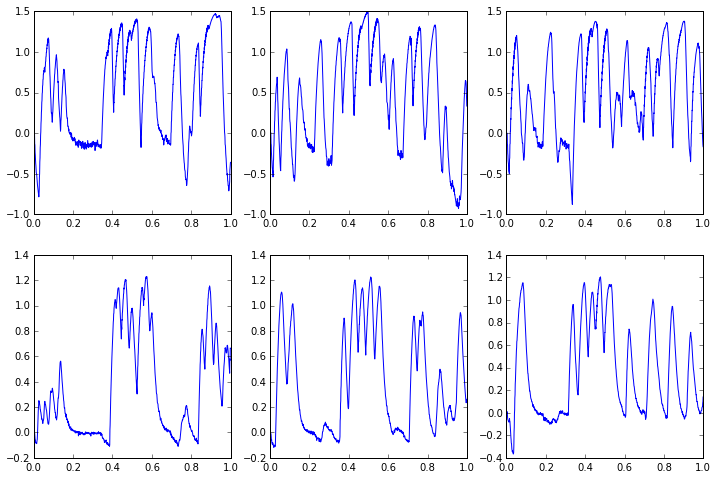

In [225]:
plt.figure(figsize=(4*n_speeds, 4*n_dirs))
for j in range(n_dirs):
    for i in range(n_speeds):
        plt.subplot(n_dirs,n_speeds,(j*n_speeds)+i+1)
        plt.plot(sim.trange(), sim.data(MT_probes[j][i]))

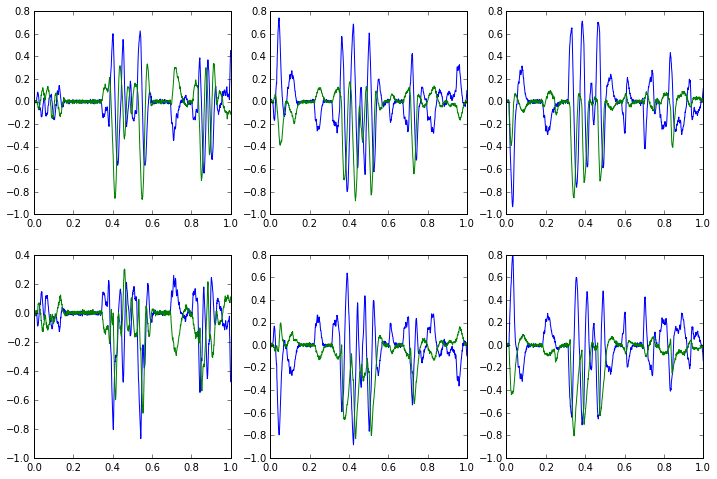

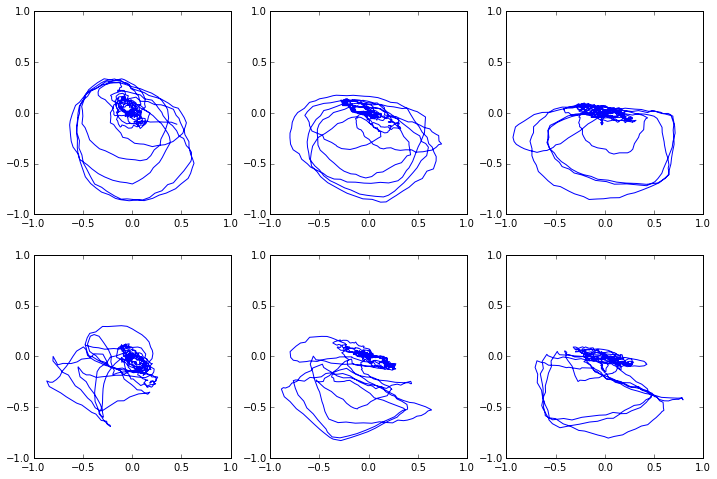

In [226]:
pop_ind = 2

plt.figure(figsize=(4*n_speeds, 4*n_dirs))
for j in range(n_dirs):
    for i in range(n_speeds):
        plt.subplot(n_dirs,n_speeds,(j*n_speeds)+i+1)
        plt.plot(sim.trange(), sim.data(V1_probes[pop_ind][j][i]))

plt.figure(figsize=(4*n_speeds, 4*n_dirs))
for j in range(n_dirs):
    for i in range(n_speeds):
        ax = plt.subplot(n_dirs,n_speeds,(j*n_speeds)+i+1)
        plt.plot(sim.data(V1_probes[pop_ind][j][i])[:,0], sim.data(V1_probes[pop_ind][j][i])[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])

# why do the periods look so similar?